# **Extracting Insights from Amazon Beauty Reviews**
**Team 1**: Danish Kamal Azmi (PM), Tzu-Chun Chen, Mahesh Wadhokar, Hanchao Tang, Yun-Hsuan Ku



## **Executive Summary**

The project uses the Amazon Beauty Review Dataset to inform companies to inform companies of customer sentiments and insights derived from customer reviews.

The data cleaning phase involved merging the reviews and metadata databases and dropping irrelevant columns. Key highlights included dropping all NA prices which was a substantial part of the dataset but any analysis without prices is incomplete. Additionally, the extensive categorization of the data was completed in this section, it did not come with the dataset.

After some EDA we focused on the reviews doing a sentiment analysis and discovering that people tend to be much more expressive when they rate something highly. It allowed us to focus on **4+ star products**, employing an LLM we used it analyze the reviews and group the data around **key themes** and **things people like**. We also analyzed products bought together and discovered people purchase more in similar categories leading to the conclusion that companies should bundle products in similar catergories. Based on the extensive analysis we propose the following recommendations for companies designing products especially in the hair, creams/lotions and eye/eyemakeup space.



*   Key satisfaction drivers: fragrance, hydration, and ease of use.

*  Repurchase & co-purchase: Nail Products, Cream/Lotion, and Perfume are most rebought

*   People purchases products in the same category together, creating space for bundles




## **Project Proposal**

**Objective:** Enhancing product design for companies by identifying positive and negative customer sentiments in a top 3 product sub-categories and frequently purchased together.

**Method**: Using Python(Pandas, MatPlotlib, Seaborn etc.) for cleaning, structuring and visualizing and OpenAi LLM to go through the reviews.

**Expected Outcome** The project should give insights into reviews and highlight core themes that are important to customers fueling product design decisions.


**Data Source:** Amazon product reviews data and metadata 1996 - 2023 https://amazon-reviews-2023.github.io/







## Team Assignment Summary

During the team Assignment phase we used the Amazon reviews for beauty products for an introductory analysis which explored the dataset and asked some initial question which set the direction of the project.

The data was cleaned dropping empty and irrelevant columns, and keeping only products with prices >0.01 (min). Additional cleaning improved readability of the data.

The report revealed that customer satisfaction is not driven by price, as many affordable products receive top ratings. Reviewes spiked during Sales season and March highlighting delays in reviews from purchase dates. We also found a strong tendency for customers to purchase multiple items from the same brand within a single order.

We recommended implementing customer retention initiatives, such as subscription models for popular consumables, and creating targeted product bundles to increase average order value. These strategies will leverage existing purchasing habits and address the significant challenge of low customer loyalty.

A summary of the cleaning is below:


####**Data Cleaning**

All the libraries that were used for this project



#####**Libraries**

In [43]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from itertools import combinations
from collections import Counter
import nltk
import textwrap
nltk.download('vader_lexicon')
pd.set_option("display.max_columns", None)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


##### Reading meta_All_Beauty json file


In [4]:
data1 = []

with open("meta_All_Beauty.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        data1.append(json.loads(line))

df1_meta = pd.DataFrame(data1)

##### Reading All_Beauty json file

In [7]:
data2 = []

with open("All_Beauty.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        data2.append(json.loads(line))

df2 = pd.DataFrame(data2)

#####**Dropping Columns**

In [10]:
#Dropping columns that are empty and irrelevant aswell products without prices listed

df1_target_data = df1_meta.drop(["images","videos","bought_together","description","categories"],axis= 1, errors = "ignore")
df2_target_data = df2.drop("images",axis = 1)
df1_clean_with_price  = df1_target_data[df1_target_data["price"] >=  0.01]


##### **Merging the two dataframes**

In [11]:
data_merged  = pd.merge(df1_clean_with_price, df2_target_data, on="parent_asin", how="left")

#Reformatting timestamp into date format
data_merged["datetime"] = pd.to_datetime(data_merged["timestamp"], unit="ms").dt.date
data_merged = data_merged.drop("timestamp" , axis = 1 )

#Renaming columns to improve readability
data_merged = data_merged.rename(columns= {"title_x" : "product_name", "title_y" : "review_title", "text" : "review_content","store":"brand"})

#Replacing empty lists [] in the features column with None, while leaving all non-empty values unchanged.
data_merged["features"] = data_merged["features"].apply(lambda x: None if x == [] else x)

#Drop null values from ratings column
data_merged = data_merged.dropna(subset=['rating'])

#Checking for nulls
data_merged.isnull().sum()

,0
main_category,0
product_name,0
average_rating,0
rating_number,0
features,72204
price,0
brand,6511
details,0
parent_asin,0
rating,0


#####**New: Categorizing the items**

In [14]:
# Function to classify products into categories based on keywords
def categorize_product(name):
    name = str(name).lower()  # make lowercase for matching

    if any(k in name for k in ["lipstick", "lip gloss", "lip balm", "lip color", "lip tint", "lip", "lpstk"]):
        return "Lip Product"

    elif any(k in name for k in ["eyebrow", "brow", "eyeliner", "eye liner", "mascara", "lash", "shadow", "liner", "eye", "lifting complex"]):
        return "Eye/Eyebrow Product"

    elif any(k in name for k in ["makeup kit", "makeup collection"]):
        return "General Makeup"

    elif any(k in name for k in ["setting spray","setting powder","foundation", "bb cream", "cc cream", "concealer","contour", "powder cheeks", "palette", "highlighter", "makeup remover", "no color powder"]):
        return "Face Makeup"

    elif any(k in name for k in ["body butter","aloe","cream", "lotion", "moisturizer", "hydrating", "hydration", "crema", "body balm", "cocoa butter", "sunscreen", "sun", "hydrant", " hydratant", "creme","body mousse"]):
        return "Cream/Lotion"

    elif any(k in name for k in ["acne", "ampoule","mask", "sheet mask", "bubble mask", "clay", "face serum", "scrub", "rejuvenating", "copper peptides", "anti wrinkle","anti aging", "skin toner"]):
        return "Face Products"

    elif any(k in name for k in ["leather","perfume", "fragrance", "eau de parfum", "edt", "edp", "elixir", "colognė", "parfum", "tobacco", "eau de toilette", "for men", "mist","cologne"]):
        return "Perfume/Fragrance"

    elif any(k in name for k in ["scalp","shampoo", "conditioner", "hair", "hair spray", "beard", "curl", "moisture leave-in", "wax", "grooming spray"]):
        return "Hair Product"

    elif any(k in name for k in ["shave","body powder","dial himalayan", "antibacterial","cleanser", "soap", "wash", "face wash", "exfoliating", "shower gel", "hand cleaner", "deodorant", "gillette", "razor", "exfoliator", "facial", "anti-perspirant"]):
        return "Personal Hygiene"

    elif any(k in name for k in ["nail", "cuticle", "polish", "ibd builder", "manicure", "pedicure", "shine e"]):
        return "Nail Product"

    elif any(k in name for k in ["toothbrush", "dental", "teeth", "gum"]):
        return "Dental Product"

    elif any(k in name for k in ["biotone bottle","clamps","crown","threadheads","headband","rack", "brush", "massage","sponge","bracelet", "odif", "wipes", "jewels", "veil", "empty travel containers", "earring", "tattoo", "piercing", "clips", "case", "tray", "pony", "wig", "scissors", "braid", "roller", "comb", "tweezer", "extractor", "band", "jewelry", "necklace", "brooch"]):
        return "Accessories"

    elif any(k in name for k in ["cancer", "nebulizer", "ointment"]):
        return "Medical"

    elif any(k in name for k in ["hair oil", "oil", "castor"]):
        return "Oils"

    elif any(k in name for k in ["big lift","mat","rolling paper","mart","crayon","sink","storage","rc", "iphone", "screen replacement", "wallet", "toy", "dog", "pet", "moss", "seasoning", "cajun", "sleeve modern","robe", "kimono","scarf","socks"]):
      return "Non-Beauty"

    else:
        return "Other Beauty Product"

# Apply to your DataFrame
data_merged['beauty_category'] = data_merged['product_name'].apply(categorize_product)

## Introduction and Motivation

When designing and positioning a product there is never enough information and data. Companies do extensive research, surveys and number crunching. This project aims to inform that process further by analyzing the vast repository that is the Amazon Reviews database. It would allow companies to utilize key themes common in all highly rated products and how they can effectively bundle products.

Our primary motivation was to utilize reviews better then just informing purchase decision but also designing decision. We considered it's vast untapped potential and visualize key findings to give a concise yet holistic view of our findings.

## Questions and Data Visualization



### Exploratory Questions

We started the project with some exploratory question to understand the dataset and set the direction for our analysis

**Is there a month where the purchases are higher then usual?**

Interestingly enough, while there are spikes in January corresponding with the sale season, the value is similar to March which does not correspond with any major sale season. The data is for when reviews were logged rather than for bought products which alludes to the possibility of a time lag between a purchase and when people review it.


In [16]:
data_merged["datetime"] = pd.to_datetime(data_merged["datetime"], format="%Y-%m-%d")

data_merged["month"] = data_merged["datetime"].dt.month
data_merged["month_name"] = data_merged["datetime"].dt.strftime("%B")

monthly_breakup = data_merged.groupby("month_name").size()

monthly_table = monthly_breakup.reset_index()
monthly_table.columns = ["Month", "Number of Reviews"]

month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
monthly_table["Month"] = pd.Categorical(monthly_table["Month"], categories=month_order, ordered=True)
monthly_table = monthly_table.sort_values("Month")

print(monthly_table)

        Month  Number of Reviews
4     January              17560
3    February              15544
7       March              17543
0       April              15652
8         May              15843
6        June              15040
5        July              16390
1      August              15458
11  September              13558
10    October              14262
9    November              13327
2    December              15446


**Does the lack of a features and description have any impact on the ratings**

The difference is negligible hence seems it does not matter or features are available in other fields

In [17]:
No_features = data_merged.dropna(subset=['features'])

average_with_features = round(No_features['average_rating'].mean(),2)

Only_none = data_merged[data_merged['features'].isna()]
average_with_none = round(Only_none['average_rating'].mean(),2)

print(f"Average rating with features is {average_with_features} while Average rating without features is {average_with_none}")

Average rating with features is 4.3 while Average rating without features is 4.26


**Among customers who reviewed on more than one date, how many reviewed the same product versus switched to different products?**

Out of 178,171 total customers, only 3,636 customers (2.0%) make reviews on more than one date. Among these repeat customers, none of them reviewed the exact same product across different dates, while all 3,636 customers (100%) bought different products on their subsequent purchases.

**What is the top 10 brands that have the most amounts of rating?**



In [18]:
brand_summary = (
    data_merged.groupby("brand")
    .size()  # count rows per brand
    .sort_values(ascending=False)
    .head(10)
)

print(brand_summary)

brand
SALUX                2183
Godefroy             1750
Makone               1374
GranNaturals         1372
Meeteasy             1343
The Curly Co.        1328
Bed Head             1244
Bath & Body Works    1209
Soft 'N Style        1164
Picoway              1153
dtype: int64


**What is the distribution of ratings and what does it shows about the bias of people who gives rating?**

This pattern (many 5s, many 1s, few 2–4s) usually means ratings are polarized by strong emotions—either delight or frustration—while neutral experiences don’t trigger reviews. It reflects these following biases, not necessarily the true quality distribution:





*   Self-Selection Bias – self-selection bias is when only people with strong opinions (positive or negative) choose to leave ratings.
*   Positivity Bias – positivity bias is when very satisfied customers are more likely to leave 5-star reviews.


*   Negativity Bias – negativity bias is when very dissatisfied customers are more likely to leave 1-star reviews.






In [19]:
counts = data_merged["rating"].value_counts().sort_index()
percentages = data_merged["rating"].value_counts(normalize=True).sort_index() * 100

rating_table = pd.DataFrame({
    "Count": counts,
    "Percentage (%)": percentages.round(0)
})

rating_table

,Count,Percentage (%)
rating,,
1.0,22632,12.0
2.0,9658,5.0
3.0,13368,7.0
4.0,18997,10.0
5.0,120968,65.0


### Analysis of reviews

At this point we started focusing on the reviews

**What is the relationship between product price and customer rating?**

Most products are priced under $100 and cluster around 4–5 stars, showing that there is no strong positive relationship between price and rating — expensive items don’t always get higher ratings and inexpensive items can still get very high ratings. The regression line adds to that analysis

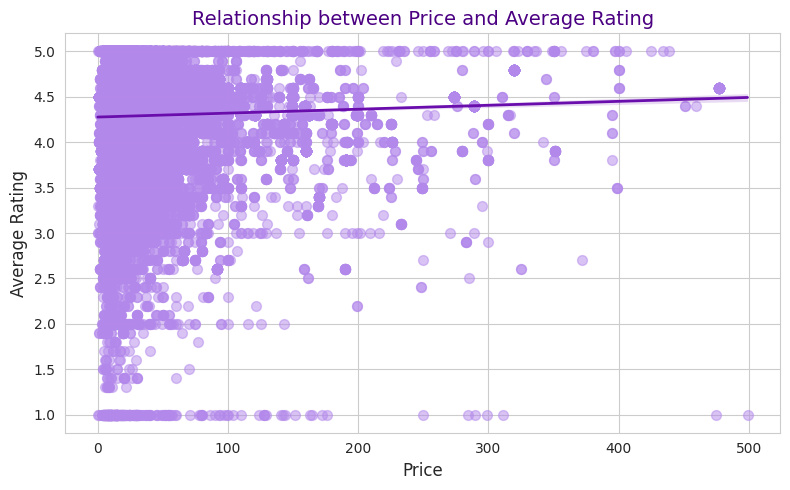

In [20]:
df_clean = data_merged[data_merged['price'] <= 500]

sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.regplot(
    data=df_clean,
    x='price',
    y='average_rating',
    scatter_kws={'color': '#B388EB', 'alpha': 0.5, 's': 50},  # soft purple
    line_kws={'color': '#6A0DAD', 'lw': 2}                     # deep purple trendline
)

plt.title('Relationship between Price and Average Rating', fontsize=14, color='#4B0082')
plt.xlabel('Price', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.tight_layout()
plt.show()


**Do higher-rated reviews receive more helpful votes overall?**

The most helpful reviews are actually the most extreme; the highly critical 1-star reviews are rated most helpful, followed by the glowing 5-star reviews.

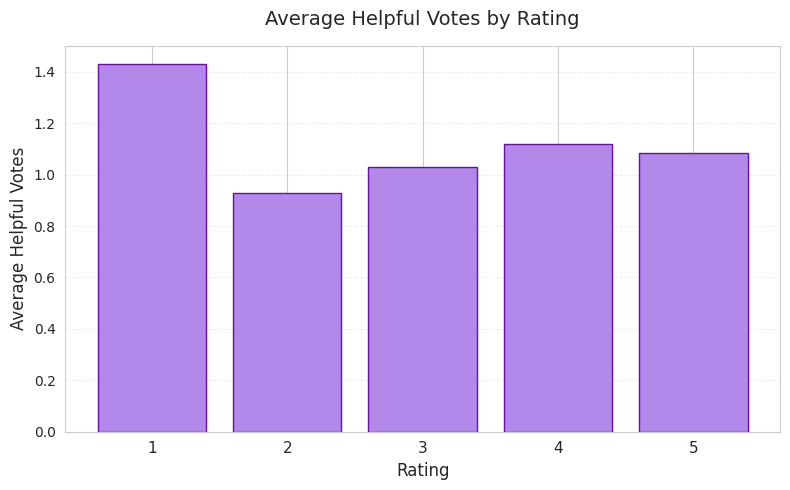

In [89]:
rating_helpful = data_merged.groupby("rating")["helpful_vote"].mean().reset_index()
sns.set_style("whitegrid")

plt.figure(figsize=(8,5))

bar_color = "#B388EB"  # light lavender
edge_color = "#6A0DAD"  # deep purple border

plt.bar(
    rating_helpful["rating"],
    rating_helpful["helpful_vote"],
    color=bar_color,
    edgecolor=edge_color,
    linewidth=1
)

plt.title("Average Helpful Votes by Rating", fontsize=14, pad=15)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Average Helpful Votes", fontsize=12)

plt.xticks([1, 2, 3, 4, 5], fontsize=11)
plt.yticks(fontsize=10)

plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()

plt.show()

**How do helpful votes vary over time? (Year-wise trend)**

The average number of helpful votes per review has drastically decreased over the years; after peaking in 2002 it fell drastically around 2005, it has fallen to a much lower and more stable level since 2010.


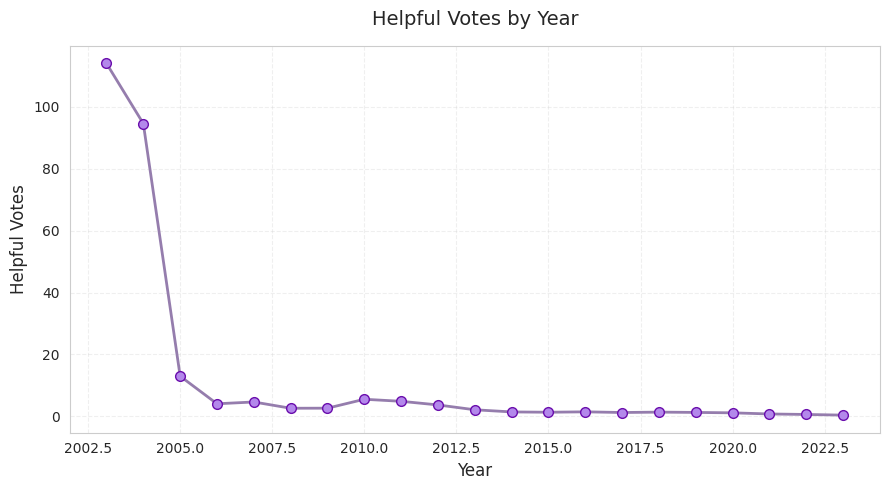

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data_merged["year"] = pd.to_datetime(data_merged["datetime"], errors="coerce").dt.year
year_helpful = data_merged.groupby("year")["helpful_vote"].mean().reset_index()

sns.set_style("whitegrid")

plt.figure(figsize=(9,5))

plt.plot(
    year_helpful["year"],
    year_helpful["helpful_vote"],
    marker='o',
    markersize=7,
    markerfacecolor="#B388EB",  # lavender
    markeredgecolor="#6A0DAD",  # deep purple outline
    linewidth=2,
    color="#957DAD"             # soft purple line
)

plt.title("Helpful Votes by Year", fontsize=14, pad=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Helpful Votes", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()

plt.show()


**What is the word cloud(the frequency of words) for different bins of rating? (from review data)**
To reduce low ratings → focus on quality control (durability, smell, packaging) and managing expectations about performance.


To increase high ratings → continue emphasizing ease of use and visible, positive results (especially for skin/beauty products).
Value perception:
Low ratings: complaints about money wasted.
High ratings: praise on worth and perfection.
Product attributes
Low ratings: negative about smell, color, bottle, breakage.
High ratings: positive about skin, scent, softness, ease.
Customer actions
Low ratings: return, disappointed → refunds & churn.
High ratings: love, perfect, recommend → repeat purchases & advocacy.


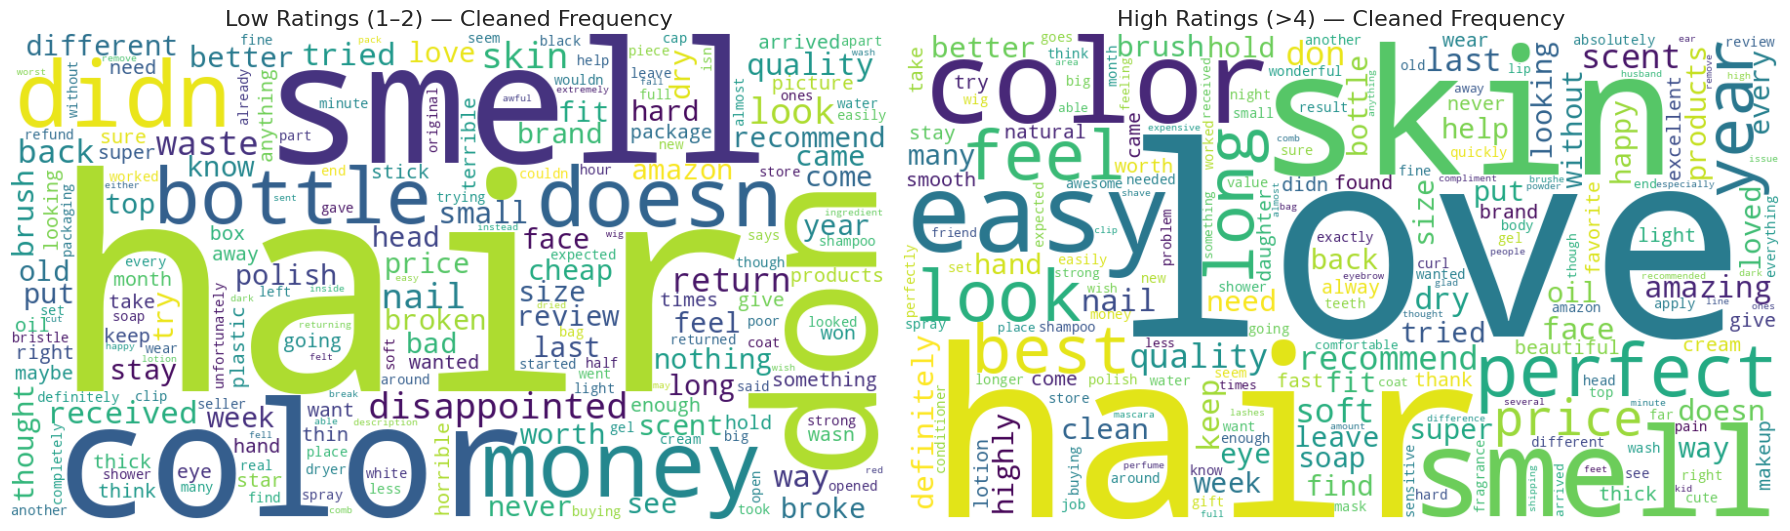

In [91]:
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"<br\s*/?>", " ", s)      # strip HTML line breaks
    s = re.sub(r"&[a-z]+;", " ", s)       # strip HTML entities
    s = re.sub(r"[^a-z\s]", " ", s)       # keep letters/spaces only
    s = re.sub(r"\s+", " ", s).strip()
    return s

def filter_tokens(text: str, bad_words: set, min_len: int = 3) -> str:
    toks = [t for t in text.split() if len(t) >= min_len and t not in bad_words]
    return " ".join(toks)

custom_sw = set(STOPWORDS)
custom_sw.update({
    # HTML / artifacts
    "br",
    # generic filler
    "use","used","using","really","much","even","also","very","still",
    "thing","things","stuff","lot","bit","actually","pretty",
    # review clichés / domain generic
    "product","item","buy","bought","purchased","order","ordered","purchase",
    "works","work","made","make","makes","get","got","getting",
    "one","two","first","second","day","days","time",
    "good","great","nice","little","well","say","will","now"
})

low_df  = data_merged[(data_merged["rating"] >= 1) & (data_merged["rating"] <= 2)]
high_df = data_merged[data_merged["rating"] > 4]

low_text_raw  = " ".join(low_df["review_content"].dropna().astype(str))
high_text_raw = " ".join(high_df["review_content"].dropna().astype(str))

low_text_clean  = filter_tokens(clean_text(low_text_raw),  custom_sw, min_len=3)
high_text_clean = filter_tokens(clean_text(high_text_raw), custom_sw, min_len=3)

wc_low = WordCloud(
    width=900, height=500, background_color="white",
    stopwords=custom_sw, collocations=False
).generate(low_text_clean)

wc_high = WordCloud(
    width=900, height=500, background_color="white",
    stopwords=custom_sw, collocations=False
).generate(high_text_clean)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes[0].imshow(wc_low, interpolation="bilinear")
axes[0].set_title("Low Ratings (1–2) — Cleaned Frequency", fontsize=16)
axes[0].axis("off")

axes[1].imshow(wc_high, interpolation="bilinear")
axes[1].set_title("High Ratings (>4) — Cleaned Frequency", fontsize=16)
axes[1].axis("off")

plt.tight_layout()
plt.show()

### Sentiment Analysis and Repeat Purchases

The wordcloud informed our decision to start focusing on the content of the reviews themselves

**How are people expressing themselves, is it similar across ratings?**

Both the Sentiment Analysis highlighted that users are much more expressive on the positve. The tend to express what they liked more and compared what they did not like. It informed our focus to be on higher rated products as more insights could be derived for it.

Columns available: Index(['main_category', 'product_name', 'average_rating', 'rating_number',
       'features', 'price', 'brand', 'details', 'parent_asin', 'rating',
       'review_title', 'review_content', 'asin', 'user_id', 'helpful_vote',
       'verified_purchase', 'datetime', 'beauty_category', 'month',
       'month_name'],
      dtype='object')


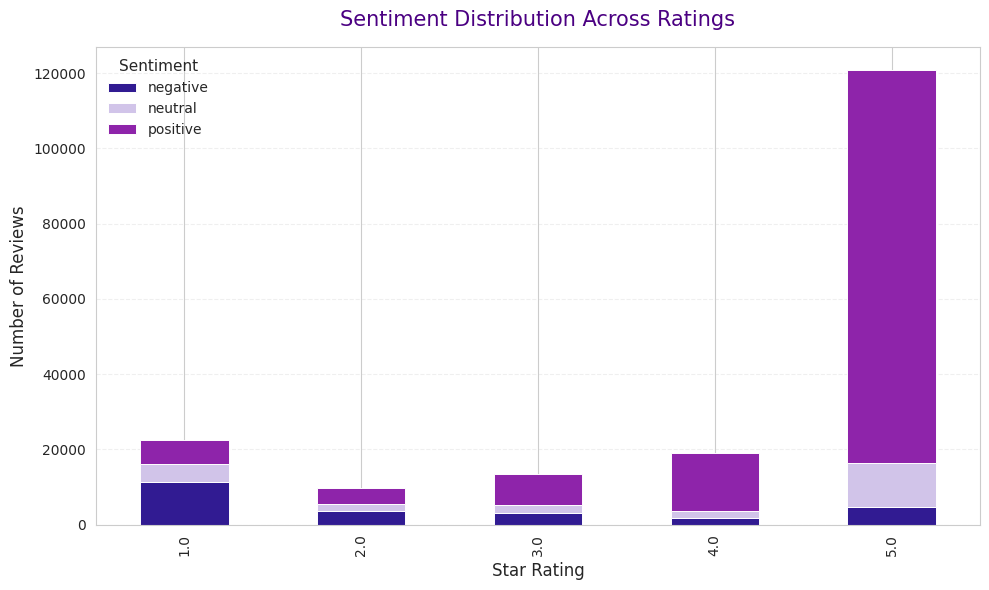

Summary of Sentiment vs Verified Status:
  sentiment  verified_purchase  avg_rating  avg_helpful   count
0  negative              False    2.362616     1.514531    1514
1  negative               True    2.388999     1.239271   23162
2   neutral              False    3.285311     1.245763     708
3   neutral               True    3.651400     0.582139   21354
4  positive              False    4.376683     1.514873    9581
5  positive               True    4.498995     1.150854  129304


In [63]:
import pandas as pd
import matplotlib.pyplot as plt


print("Columns available:", data_merged.columns)

data_merged["review_content"] = data_merged["review_content"].fillna("")

sentiment_df = data_merged[["rating", "review_content", "verified_purchase", "helpful_vote"]].dropna(subset=["rating"])

sia = SentimentIntensityAnalyzer()
sentiment_df["sentiment_score"] = sentiment_df["review_content"].apply(lambda x: sia.polarity_scores(x)["compound"])

def sentiment_label(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

sentiment_df["sentiment"] = sentiment_df["sentiment_score"].apply(sentiment_label)

sentiment_by_rating = sentiment_df.groupby(["rating", "sentiment"]).size().unstack(fill_value=0)

sns.set_style("whitegrid")

custom_palette = {
    "positive": "#8E24AA",   # medium magenta-violet
    "neutral":  "#D1C4E9",   # light lilac
    "negative": "#311B92"    # very deep indigo
}

color_list = [custom_palette.get(col, "#B388EB") for col in sentiment_by_rating.columns]

ax = sentiment_by_rating.plot(
    kind="bar",
    stacked=True,
    figsize=(10,6),
    color=color_list,
    edgecolor="white",
    linewidth=0.7
)

ax.set_title("Sentiment Distribution Across Ratings", fontsize=15, color="#4B0082", pad=15)
ax.set_xlabel("Star Rating", fontsize=12)
ax.set_ylabel("Number of Reviews", fontsize=12)
ax.tick_params(axis='x')
ax.tick_params(axis='y')
ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.legend(title="Sentiment", title_fontsize=11, fontsize=10, frameon=False)
plt.tight_layout()
plt.show()

summary = sentiment_df.groupby(["sentiment", "verified_purchase"]).agg(
    avg_rating=("rating", "mean"),
    avg_helpful=("helpful_vote", "mean"),
    count=("rating", "count")
).reset_index()

print("Summary of Sentiment vs Verified Status:")
print(summary)

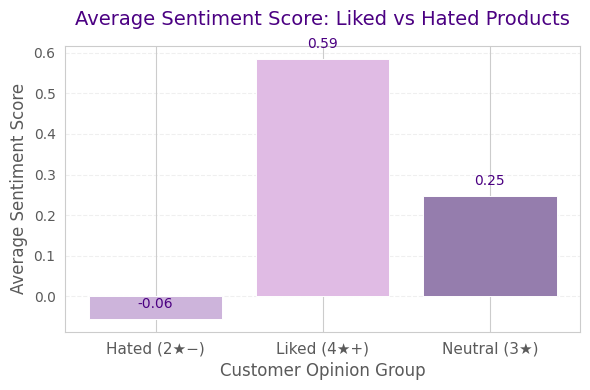

In [109]:
def product_opinion(rating):
    if rating >= 4:
        return "Liked (4★+)"
    elif rating <= 2:
        return "Hated (2★−)"
    else:
        return "Neutral (3★)"

sentiment_df["opinion_group"] = sentiment_df["rating"].apply(product_opinion)

avg_sentiment_group = (
    sentiment_df.groupby("opinion_group")["sentiment_score"]
    .mean()
    .reset_index()
)

colors = ["#CDB4DB", "#E0BBE4", "#957DAD"]  # soft lilac tones

plt.figure(figsize=(6,4))
bars = plt.bar(
    avg_sentiment_group["opinion_group"],
    avg_sentiment_group["sentiment_score"],
    color=colors,
    edgecolor="white",
    linewidth=0.7
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height + 0.02,
        f"{height:.2f}",
        ha='center', va='bottom', fontsize=10, color="#4B0082"
    )

plt.title("Average Sentiment Score: Liked vs Hated Products", fontsize=14, color="#4B0082", pad=15)
plt.xlabel("Customer Opinion Group", fontsize=12, color="#5A5A5A")
plt.ylabel("Average Sentiment Score", fontsize=12, color="#5A5A5A")
plt.xticks(fontsize=11, color="#5A5A5A")
plt.yticks(fontsize=10, color="#5A5A5A")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()
plt.show()

**Are customers doing repeat purchases?**

A cursory glane at repeat purchases at this point showed which products are frequently repurchased. It highlighted the need to re-visit this to see if some insights could be derived.

In [64]:
df = data_merged.copy()
df = df[df["verified_purchase"] == True]
df = df.drop_duplicates(subset=["user_id", "parent_asin", "datetime"])

purchase_counts = (
    df.groupby(["user_id", "parent_asin"])
      .size()
      .reset_index(name="count")
)
purchase_counts["repeat_count"] = purchase_counts["count"] - 1
repeat_purchase = purchase_counts[purchase_counts["repeat_count"] > 0]

asin_repeat_stats = (
    repeat_purchase.groupby("parent_asin")
    .agg(total_repeat=("repeat_count", "sum"),
         num_users=("user_id", "nunique"))
    .reset_index()
    .sort_values("total_repeat", ascending=False)
)

asin_repeat_stats_named = (
    asin_repeat_stats
    .merge(
        df[["parent_asin", "product_name", "average_rating", "price"]].drop_duplicates(),
        on="parent_asin",
        how="left"
    )
)

asin_repeat_stats_named["beauty_category"] = (
    asin_repeat_stats_named["product_name"].apply(categorize_product)
)

cols_to_show = [
    "parent_asin", "product_name", "beauty_category",
    "total_repeat", "num_users", "average_rating", "price"
]

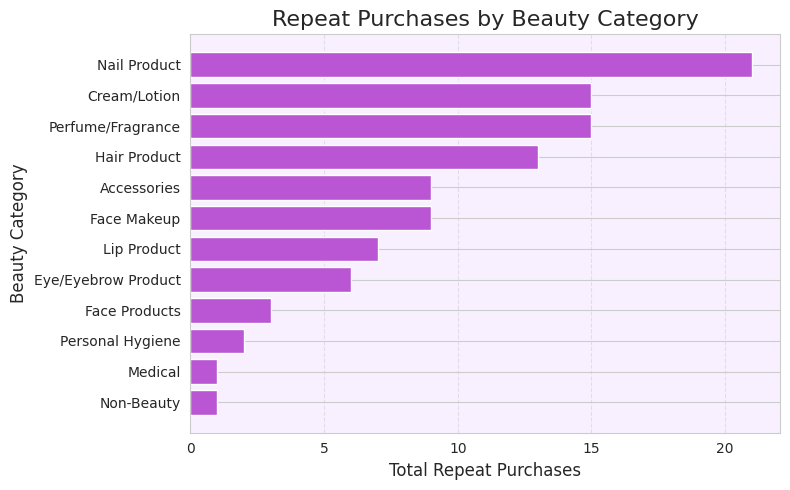

In [115]:
category_summary = (
    asin_repeat_stats_named.groupby("beauty_category", as_index=False)
    .agg(total_repeat=("total_repeat", "sum"))
    .sort_values("total_repeat", ascending=False)
)

lavender_color = "#D8BFD8"  # light lavender
bar_colors = "#BA55D3"      # medium purple for bars

plt.figure(figsize=(8, 5))
plt.barh(
    category_summary["beauty_category"],
    category_summary["total_repeat"],
    color=bar_colors
)

plt.xlabel("Total Repeat Purchases", fontsize=12)
plt.ylabel("Beauty Category", fontsize=12)
plt.title("Repeat Purchases by Beauty Category", fontsize=16)

plt.xticks(
    range(0, int(category_summary["total_repeat"].max()) + 1, 5))
plt.yticks()

plt.gca().invert_yaxis()

plt.gca().set_facecolor("#F8F0FF")
plt.grid(axis='x', linestyle='--', alpha=0.5)  # subtle grid

plt.tight_layout()
plt.show()

### LLM Analysis Review
What are the reviews themselves saying can they be grouped to inform decision making ?

We utilized ChatGPTs API to go through the reviews themselves and bunch them together around a few key themes to visualize. We focused on the top 3 categories by count in the interest of time and limited resources.

In [28]:
df = data_merged

from google.colab import userdata
api_key = userdata.get('OpenAI')   # <-- must match your secret’s name exactly
print(api_key is not None)

cat = "Hair Product"  # example
dfc = df[(df["beauty_category"]==cat) & df["review_content"].notna()].copy()
hi = dfc[dfc["rating"]>=4]
lo = dfc[dfc["rating"]<=2]
texts = hi["review_content"].dropna().astype(str).tolist()


True


In [56]:
import os
import math
from openai import OpenAI


os.environ["OPENAI_API_KEY"] = "Can't show"

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
print("Client ready!")

df = data_merged

cat = "Hair Product"
dfc = df[(df["beauty_category"]==cat) & df["review_content"].notna()].copy()
hi = dfc[dfc["rating"] >= 4]


def _prep_texts(series, max_chars=600):
    s = series.dropna().astype(str).str.strip()
    s = s[s.str.len() > 0]
    return s.str.slice(0, max_chars).tolist()

def _chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]


def _summarize_batch_text(reviews, category="Hair Product"):
    joined = "\n".join(f"- {t}" for t in reviews)
    prompt = f"""
You are analyzing Amazon reviews for category: {category}, rating >= 4.
Write a concise, structured text summary using short bullet points and headers.

Use exactly these sections:
1) Top Themes (5–8 bullets)
2) What makes customers especially happy (3–6 bullets)

Base ONLY on the snippets below. Avoid repetition. Be concrete.
Snippets:
{joined}
"""
    r = client.responses.create(model="gpt-4o-mini", input=prompt)
    return r.output_text

def _reduce_text_summaries(batch_texts, category="Hair Product"):
    joined = "\n\n--- BATCH ---\n\n".join(batch_texts)
    prompt = f"""
You will receive multiple batch summaries for {category} reviews (rating >= 4).
Merge them into ONE concise, non-redundant text with the same 5 sections:

1) Top Themes (5–8 bullets)
2) What Delights Customers (3–6 bullets)

Rules: Merge overlapping points, keep wording tight, avoid repetition, no JSON, just clean text.
Batch summaries:
{joined}
"""
    r = client.responses.create(model="gpt-4o-mini", input=prompt)
    return r.output_text

def summarize_all_high_reviews_text(df_hi, category="Hair Product", batch_size=150, max_chars=600):
    texts = _prep_texts(df_hi["review_content"], max_chars=max_chars)
    batches = list(_chunks(texts, batch_size))
    batch_summaries = []
    for i, b in enumerate(batches, 1):
        if len(b) < 5:  # skip tiny trailing batch (optional)
            continue
        batch_summaries.append(_summarize_batch_text(b, category=category))
    final_text = _reduce_text_summaries(batch_summaries, category=category)
    return final_text

final_summary_text = summarize_all_high_reviews_text(hi, category="Hair Product", batch_size=150, max_chars=600)
print(final_summary_text)

Client ready!
## Top Themes
- **Quality and Durability**: Customers consistently praise the high quality and durable nature of various hair products, including wigs, conditioners, and tools.
- **Ease of Use**: Many reviews highlight the simplicity of application, making hair care and styling accessible for users of all experience levels.
- **Versatility**: Products cater to a variety of hair types and styling needs, from curls and waves to straight and sleek looks, appealing to a broad audience.
- **Pleasant Fragrances**: The enjoyable scents of products contribute to an enhanced user experience, often noted as a significant factor in customer satisfaction.
- **Value for Money**: Buyers frequently express satisfaction with the quality relative to price, considering many products a worthwhile investment.
- **Effective Results**: Numerous users report visible improvements in hair texture, manageability, and overall appearance after product use.
- **Positive Customer Experiences**: Fast s

/tmp/ipython-input-1432682218.py:75: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  hits = {t: texts.str.contains(rx, regex=True) for t, rx in compiled_group.items()}


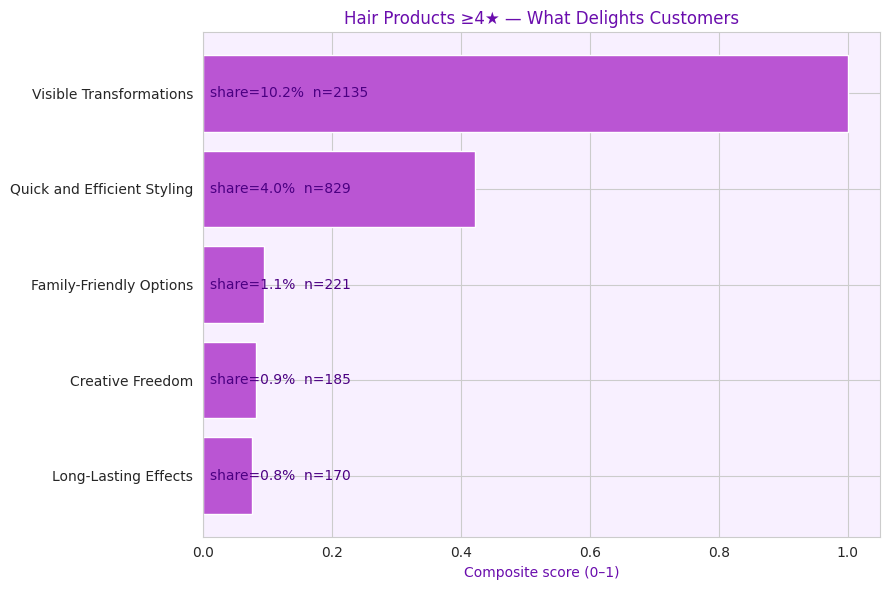

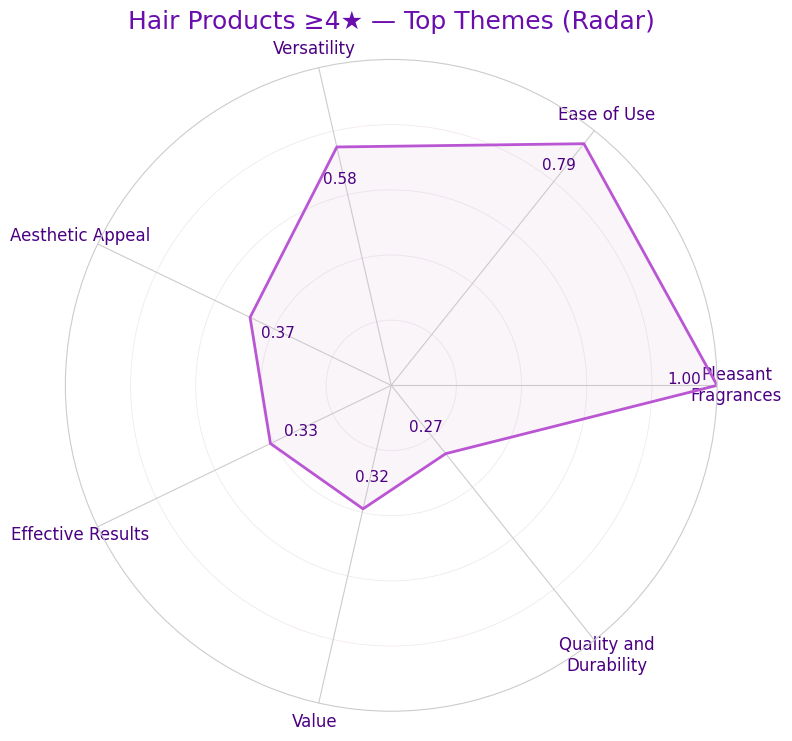

In [61]:
df = data_merged

cat = "Hair Product"
dfc = df[(df["beauty_category"]==cat) & df["review_content"].notna()].copy()
hi = dfc[dfc["rating"]>=4].copy()
lo = dfc[dfc["rating"]<=2].copy()
texts = hi["review_content"].dropna().astype(str).tolist()

if "helpful_vote" not in hi.columns:
    hi["helpful_vote"] = 0.0
hi["helpful_vote"] = pd.to_numeric(hi["helpful_vote"], errors="coerce").fillna(0.0)
text_series = hi["review_content"].fillna("").astype(str)


THEMES_GROUPED = {
    "Top Themes": {
        "Quality and Durability": [
            r"\b(high[-\s]?quality|premium|durable|sturdy|long[-\s]?lasting|robust|well[-\s]?made)\b"
        ],
        "Ease of Use": [
            r"\b(easy|simple|user[-\s]?friendly|beginner|quick|convenient|effortless|accessible)\b",
            r"\b(application|usage|handling)\b"
        ],
        "Versatility": [
            r"\b(versatil(e|ity)|multi[-\s]?use|various|all[-\s]?hair\s+types|styling\s+needs|curls|waves|straight|sleek|different\s+hairstyles?)\b"
        ],
        "Pleasant Fragrances": [
            r"\b(pleasant|enjoyable|nice|refreshing|uplifting|fragrance|scent|smell|aroma|cool)\b"
        ],
        "Value for Money": [
            r"\b(value|worth|affordab(le|ly)|investment|quality\s+relative\s+to\s+price|cost-effective|budget[-\s]?friendly)\b"
        ],
        "Effective Results": [
            r"\b(effective|results?|improv(ed|ement)?|enhance(d)?|better\s+manageability|texture|appearance|visible\s+improvements)\b"
        ],
        "Positive Customer Experiences": [
            r"\b(customer\s+service|support|shipping|fast\s+delivery|responsive|satisfaction|loyalty)\b"
        ],
        "Aesthetic Appeal": [
            r"\b(attractive|beautiful|appealing|packaging|design|presentation|eye[-\s]?catching)\b"
        ]
    },

    "What Delights Customers": {
        "Visible Transformations": [
            r"\b(soft|smooth|shine|shiny|bounce|healthy\s+looking|visible\s+improv(ed|ement)?|transformation|enhanced\s+hair\s+quality)\b"
        ],
        "Quick and Efficient Styling": [
            r"\b(quick|fast|rapid|efficient|time[-\s]?saving|styling\s+without\s+compromise|curling\s+irons|blow\s+dry(er)?)\b"
        ],
        "Family-Friendly Options": [
            r"\b(children|kids?|family[-\s]?friendly|all\s+ages|safe\s+for\s+kids)\b"
        ],
        "Long-Lasting Effects": [
            r"\b(long[-\s]?lasting|durable|retention|holds?\s+throughout\s+the\s+day|no\s+reapplication|all[-\s]?day\s+effect)\b"
        ],
        "Creative Freedom": [
            r"\b(creativ(e|ity)|versatile|different\s+hairstyles?|casual|formal|easy\s+to\s+style|flexible|freedom\s+to\s+experiment)\b"
        ]
    }
}


THEMES_RE = {group: {t: re.compile("|".join(pats), re.I) for t, pats in themes.items()}
             for group, themes in THEMES_GROUPED.items()}


def score_group(texts, df, compiled_group):
    hits = {t: texts.str.contains(rx, regex=True) for t, rx in compiled_group.items()}
    counts = {t: m.sum() for t, m in hits.items()}
    N = len(texts)
    share = {t: counts[t]/max(N,1) for t in counts}
    helpful = pd.to_numeric(df["helpful_vote"], errors="coerce").fillna(0.0)
    w_sum = {t: float(helpful.loc[m].sum()) for t, m in hits.items()}
    max_w = max(w_sum.values()) if len(w_sum) else 1.0
    w_norm = {t: (w_sum[t]/max_w if max_w>0 else 0.0) for t in w_sum}
    max_share = max(share.values()) if len(share) else 1.0
    share_norm = {t: (share[t]/max_share if max_share>0 else 0.0) for t in share}
    score = {t: 0.8*share_norm[t] + 0.2*w_norm[t] for t in share}
    df_out = pd.DataFrame({
        "theme": list(counts.keys()),
        "count": list(counts.values()),
        "share": [share[t] for t in counts],
        "helpful_sum": [w_sum[t] for t in counts],
        "helpful_norm": [w_norm[t] for t in counts],
        "share_norm": [share_norm[t] for t in counts],
        "score": [score[t] for t in counts],
    }).sort_values("score", ascending=False).reset_index(drop=True)
    return df_out, hits

group_scores, group_hits = {}, {}
for group, comp in THEMES_RE.items():
    df_out, hits = score_group(text_series, hi, comp)
    group_scores[group] = df_out
    group_hits[group] = hits


def plot_group_bar(df_group, title, topn=None):
    plot_df = df_group.copy()
    if topn: plot_df = plot_df.head(topn)
    plot_df = plot_df.iloc[::-1]
    plt.figure(figsize=(9,6))
    plt.barh(plot_df["theme"], plot_df["score"], color="#BA55D3")
    for i,(s,c) in enumerate(zip(plot_df["share"], plot_df["count"])):
        plt.text(0.01, i, f"share={s:.1%}  n={int(c)}", va="center", color="#4B0082")
    plt.xlabel("Composite score (0–1)", color="#6A0DAD")
    plt.title(title, color="#6A0DAD")
    plt.gca().set_facecolor("#F8F0FF")
    plt.tight_layout()
    plt.show()

def radar_plot_balanced(
    df_in,
    value_col="score",
    k=6,
    title="Theme Radar",
    label_map=None,
    mode="percentile",
    show_rings=True,
    show_rlabels=False,
    annotate="inside",
    wrap_width=16
):
    dfp = df_in.head(k).copy().reset_index(drop=True)
    raw_labels = dfp["theme"].tolist()
    labels = [label_map.get(t, t) for t in raw_labels] if label_map else raw_labels
    labels = [textwrap.fill(l, wrap_width) for l in labels]
    vals = dfp[value_col].to_numpy(float)
    if mode == "rank":
        ranks = dfp[value_col].rank(method="average").to_numpy()
        vals_scaled = (ranks - 1) / max(len(ranks) - 1, 1)
    else:
        ref = df_in[value_col].to_numpy(float)
        p10, p90 = np.percentile(ref, [10, 90])
        vals_clip = np.clip(vals, p10, p90)
        vals_scaled = (vals_clip - p10) / max(p90 - p10, 1e-8)
        vals_scaled = np.sqrt(vals_scaled)
    values = vals_scaled.tolist() + [vals_scaled[0]]
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    if show_rings:
        rticks = [0.2, 0.4, 0.6, 0.8]
        ax.set_yticks(rticks)
        ax.set_ylim(0, 1)
        ax.yaxis.grid(True, linestyle='-', linewidth=0.6, alpha=0.35, color="#D8BFD8")
        ax.set_yticklabels([]) if not show_rlabels else ax.set_yticklabels([f"{int(t*100)}%" for t in rticks], fontsize=10, color="#4B0082")
    else:
        ax.set_yticks([]); ax.set_yticklabels([]); ax.set_ylim(0, 1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12, color="#4B0082")
    ax.plot(angles, values, linewidth=2, color="#BA55D3")
    ax.fill(angles, values, alpha=0.15, color="#D8BFD8")
    for ang, v, raw in zip(angles[:-1], values[:-1], vals):
        r = max(0.06, v - 0.10)
        ax.text(ang + 0.02, r, f"{raw:.2f}", ha="center", va="center", fontsize=11, color="#4B0082")
    ax.set_title(title, pad=22, fontsize=18, color="#6A0DAD")
    plt.tight_layout()
    plt.show()

plot_group_bar(group_scores["What Delights Customers"], "Hair Products ≥4★ — What Delights Customers", topn=5)
label_map = {
    "Quality and Effectiveness": "Quality/Effectiveness",
    "Ease of Use": "Ease of Use",
    "Comfort and Durability": "Comfort/Durability",
    "Versatility": "Versatility",
    "Pleasant Scents": "Fragrance",
    "Value for Money": "Value",
    "Travel-Friendly Designs": "Travel-Friendly",
}
radar_plot_balanced(
    df_in=group_scores["Top Themes"],
    k=7,
    title="Hair Products ≥4★ — Top Themes (Radar)",
    label_map=label_map,
    show_rings=True,       # keep rings
    show_rlabels=False,    # hide numeric labels on rings
    mode="percentile",
    wrap_width=18
)

The visualization reveals key themes that people are talking about and what they like about the products. They talk the most about the pleasant fragrance and ease of use in their reviews followed versatility. Visible transformation seems to be the highlight of well rated hair products followed closely by quick and efficient styling. How effective and easy to use a product is seems to delight customers the most for hair products.

In [58]:
df = data_merged

os.environ["OPENAI_API_KEY"] = "Can't show"

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
print("Client ready!")

cat = "Cream/Lotion"  # example
dfc = df[(df["beauty_category"]==cat) & df["review_content"].notna()].copy()
hi = dfc[dfc["rating"]>=4]
lo = dfc[dfc["rating"]<=2]
texts = hi["review_content"].dropna().astype(str).tolist()


import math
from openai import OpenAI

def _prep_texts(series, max_chars=600):
    s = series.dropna().astype(str).str.strip()
    s = s[s.str.len() > 0]
    return s.str.slice(0, max_chars).tolist()

def _chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

def _summarize_batch_text(reviews, category="Cream/Lotion"):
    joined = "\n".join(f"- {t}" for t in reviews)
    prompt = f"""
You are analyzing Amazon reviews for category: {category}, rating >= 4.
Write a concise, structured text summary using short bullet points and headers.

Use exactly these sections:
1) Top Themes (5–8 bullets)
2) What Delights Customers (3–6 bullets)

Base ONLY on the snippets below. Avoid repetition. Be concrete.
Snippets:
{joined}
"""
    r = client.responses.create(model="gpt-4o-mini", input=prompt)
    return r.output_text

def _reduce_text_summaries(batch_texts, category="Cream/Lotion"):
    joined = "\n\n--- BATCH ---\n\n".join(batch_texts)
    prompt = f"""
You will receive multiple batch summaries for {category} reviews (rating >= 4).
Merge them into ONE concise, non-redundant text with the same 5 sections:

1) Top Themes (5–8 bullets)
2) What Delights Customers (3–6 bullets)

Rules: Merge overlapping points, keep wording tight, avoid repetition, no JSON, just clean text.
Batch summaries:
{joined}
"""
    r = client.responses.create(model="gpt-4o-mini", input=prompt)
    return r.output_text

def summarize_all_high_reviews_text(df_hi, category="Cream/Lotion", batch_size=150, max_chars=600):
    texts = _prep_texts(df_hi["review_content"], max_chars=max_chars)
    batches = list(_chunks(texts, batch_size))
    batch_summaries = []
    for i, b in enumerate(batches, 1):
        if len(b) < 5:  # skip tiny trailing batch
            continue
        batch_summaries.append(_summarize_batch_text(b, category=category))
    final_text = _reduce_text_summaries(batch_summaries, category=category)
    return final_text

final_summary_text = summarize_all_high_reviews_text(hi, category="Cream/Lotion", batch_size=200, max_chars=350)
print(final_summary_text)

Client ready!
## Top Themes
- **Efficacy and Hydration**: Customers frequently report remarkable improvements in skin texture, hydration, and softness, particularly for dry skin types and conditions like eczema and psoriasis.
- **Pleasant Scents**: Scents such as lavender, citrus, and vanilla enhance the user experience, with many users appreciating the pleasant fragrances.
- **Texture and Absorption**: Many products are noted for their creamy, non-greasy textures that absorb quickly, leaving skin feeling smooth and refreshed.
- **Multi-Purpose Use**: These creams and lotions are often versatile, effective for a range of applications, including skincare, hair care, and even as aftershave or during tanning.
- **Suitable for Sensitive Skin**: Reviewers highlight the gentle formulations ideal for sensitive skin, with minimal irritation reported, making them suitable for the entire family.
- **Value for Money**: Users express satisfaction with product pricing, often finding good deals that

/tmp/ipython-input-1919217866.py:82: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  hits = {t: texts.str.contains(rx, regex=True) for t, rx in compiled_group.items()}


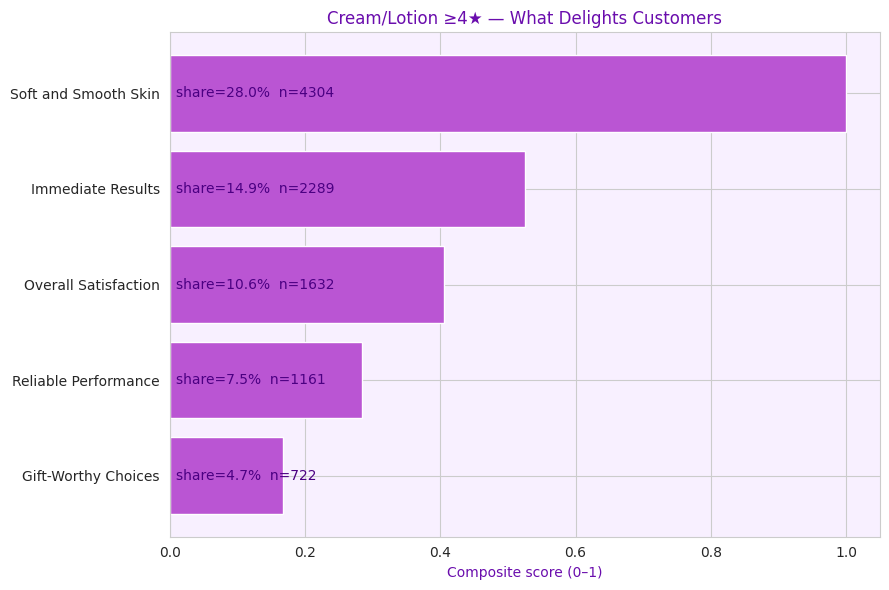

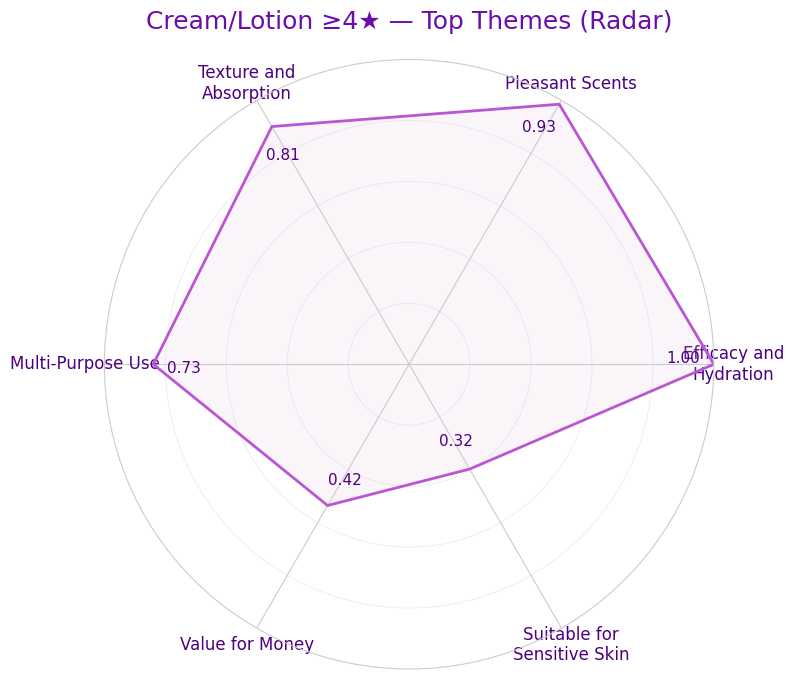

No strong co-occurrences at current thresholds.


In [60]:
df = data_merged

cat = "Cream/Lotion"  # example
dfc = df[(df["beauty_category"]==cat) & df["review_content"].notna()].copy()
hi = dfc[dfc["rating"]>=4]
lo = dfc[dfc["rating"]<=2]
texts = hi["review_content"].dropna().astype(str).tolist()

hi = hi.copy()
if "helpful_vote" not in hi.columns:
    hi["helpful_vote"] = 0.0
hi["helpful_vote"] = pd.to_numeric(hi["helpful_vote"], errors="coerce").fillna(0.0)
text_series = hi["review_content"].fillna("").astype(str)

THEMES_GROUPED = {
    "Top Themes": {
        "Efficacy and Hydration": [
            r"\b(effectiv(e|eness)|efficacy|results?|improv(ed)?|hydration|hydrate|moistur(e|ing|er)|soft(en|ness)?)\b",
            r"\b(dry(ness)?|dehydrat(ed|ion)|eczema|psoriasis|sensitive\s+skin)\b"
        ],
        "Pleasant Scents": [
            r"\b(scent|smell|fragrance|aroma)\b",
            r"\b(lavender|citrus|vanilla|pleasant|enjoyable|refreshing|uplifting)\b"
        ],
        "Texture and Absorption": [
            r"\b(texture|creamy|smooth|soft|silky|light|non[-\s]?greasy|non[-\s]?oily|rich|luxurious)\b",
            r"\b(absorb(s|ed|ing)?\s+quick(ly)?|fast[-\s]?absorbing|soaks?\s+in|penetrates?\s+quick(ly)?)\b"
        ],
        "Multi-Purpose Use": [
            r"\b(versatil(e|ity)|multi[-\s]?use|all[-\s]?over|feet|hair|aftershave|tanning)\b"
        ],
        "Suitable for Sensitive Skin": [
            r"\b(gentle|mild|non[-\s]?irritating|soothe(s|d|ing)?|calm(s|ed|ing)?|safe\s+for\s+all\s+ages|family[-\s]?friendly)\b",
            r"\b(sensitive|allerg(y|ic)|kids?|children|baby|toddler)\b"
        ],
        "Value for Money": [
            r"\b(value|affordab(le|ly)|price[dy]?|worth|deal|cost[-\s]?effective)\b"
        ],
        "Long-Lasting Effects": [
            r"\b(long[-\s]?lasting|durable|persistent|consist(ent|ency)|little\s+product\s+goes\s+a\s+long\s+way)\b"
        ],
        "Healing Properties": [
            r"\b(heal(s|ing)?|soothe(s|d|ing)?|repair|relief|calm|reduce(s|d)?\s+(irritation|redness|burns|cuts))\b"
        ]
    },

    "What Delights Customers": {
        "Immediate Results": [
            r"\b(immediate|instant|right\s+away|first\s+use|quick|fast)\b",
            r"\b(improv(e|ed|es|ement)|hydration|soft(en|ness)?|smooth|silky)\b"
        ],
        "Soft and Smooth Skin": [
            r"\b(soft|smooth|silky|luxurious|supple|plush|velvety)\b",
            r"\b(feel|touch|skin|complexion)\b"
        ],
        "Reliable Performance": [
            r"\b(loyal|repeat\s*(buy|purchase)|repurchase|staple|consistent|trust(ed)?|reliable)\b",
            r"\b(positive\s+experience|long[-\s]?term\s+use|satisfaction|recommend(ed)?)\b"
        ],
        "Gift-Worthy Choices": [
            r"\b(gift|gift[-\s]?worthy|presentable|pretty|appealing|attractive|packag(e|ing)|design)\b"
        ],
        "Overall Satisfaction": [
            r"\b(satisfact(ed|ion)|happy|pleased|content|delighted|recommend(ed)?)\b",
            r"\b(loyalty|trust|repeat\s+purchase|brand[-\s]?trust)\b"
        ]
    }
}
THEMES_RE = {
    group: {t: re.compile("|".join(pats), re.I) for t, pats in themes.items()}
    for group, themes in THEMES_GROUPED.items()
}


def score_group(texts, df, compiled_group):
    hits = {t: texts.str.contains(rx, regex=True) for t, rx in compiled_group.items()}
    counts = {t: m.sum() for t, m in hits.items()}
    N = len(texts)
    share = {t: counts[t]/max(N,1) for t in counts}

    helpful = pd.to_numeric(df["helpful_vote"], errors="coerce").fillna(0.0)
    w_sum = {t: float(helpful.loc[m].sum()) for t, m in hits.items()}

    max_w = max(w_sum.values()) if len(w_sum) else 1.0
    w_norm = {t: (w_sum[t]/max_w if max_w>0 else 0.0) for t in w_sum}

    max_share = max(share.values()) if len(share) else 1.0
    share_norm = {t: (share[t]/max_share if max_share>0 else 0.0) for t in share}

    score = {t: 0.8*share_norm[t] + 0.2*w_norm[t] for t in share}

    df_out = pd.DataFrame({
        "theme": list(counts.keys()),
        "count": list(counts.values()),
        "share": [share[t] for t in counts],
        "helpful_sum": [w_sum[t] for t in counts],
        "helpful_norm": [w_norm[t] for t in counts],
        "share_norm": [share_norm[t] for t in counts],
        "score": [score[t] for t in counts],
    }).sort_values("score", ascending=False).reset_index(drop=True)
    return df_out, hits

group_scores, group_hits = {}, {}
for group, comp in THEMES_RE.items():
    df_out, hits = score_group(text_series, hi, comp)
    group_scores[group] = df_out
    group_hits[group] = hits

def plot_group_bar(df_group, title, topn=None):
    plot_df = df_group.copy()
    if topn: plot_df = plot_df.head(topn)
    plot_df = plot_df.iloc[::-1]
    plt.figure(figsize=(9,6))
    plt.barh(plot_df["theme"], plot_df["score"], color="#BA55D3")
    for i,(s,c) in enumerate(zip(plot_df["share"], plot_df["count"])):
        plt.text(0.01, i, f"share={s:.1%}  n={int(c)}", va="center", color="#4B0082")
    plt.xlabel("Composite score (0–1)", color="#6A0DAD")
    plt.title(title, color="#6A0DAD")
    plt.gca().set_facecolor("#F8F0FF")
    plt.tight_layout()
    plt.show()

def radar_plot_balanced(
    df_in,
    value_col="score",
    k=6,
    title="Theme Radar",
    label_map=None,
    mode="percentile",
    show_rings=True,
    show_rlabels=False,
    annotate="inside",
    wrap_width=16
):
    dfp = df_in.head(k).copy().reset_index(drop=True)
    raw_labels = dfp["theme"].tolist()
    labels = [label_map.get(t, t) for t in raw_labels] if label_map else raw_labels
    labels = [textwrap.fill(l, wrap_width) for l in labels]
    vals = dfp[value_col].to_numpy(float)
    if mode == "rank":
        ranks = dfp[value_col].rank(method="average").to_numpy()
        vals_scaled = (ranks - 1) / max(len(ranks) - 1, 1)
    else:
        ref = df_in[value_col].to_numpy(float)
        p10, p90 = np.percentile(ref, [10, 90])
        vals_clip = np.clip(vals, p10, p90)
        vals_scaled = (vals_clip - p10) / max(p90 - p10, 1e-8)
        vals_scaled = np.sqrt(vals_scaled)
    values = vals_scaled.tolist() + [vals_scaled[0]]
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    if show_rings:
        rticks = [0.2, 0.4, 0.6, 0.8]
        ax.set_yticks(rticks)
        ax.set_ylim(0, 1)
        ax.yaxis.grid(True, linestyle='-', linewidth=0.6, alpha=0.35, color="#D8BFD8")
        ax.set_yticklabels([]) if not show_rlabels else ax.set_yticklabels([f"{int(t*100)}%" for t in rticks], fontsize=10, color="#4B0082")
    else:
        ax.set_yticks([]); ax.set_yticklabels([]); ax.set_ylim(0, 1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12, color="#4B0082")
    ax.plot(angles, values, linewidth=2, color="#BA55D3")
    ax.fill(angles, values, alpha=0.15, color="#D8BFD8")
    for ang, v, raw in zip(angles[:-1], values[:-1], vals):
        r = max(0.06, v - 0.10)
        ax.text(ang + 0.02, r, f"{raw:.2f}", ha="center", va="center", fontsize=11, color="#4B0082")
    ax.set_title(title, pad=22, fontsize=18, color="#6A0DAD")
    plt.tight_layout()
    plt.show()

plot_group_bar(
    group_scores["What Delights Customers"],
    "Cream/Lotion ≥4★ — What Delights Customers",
    topn=8
)

cream_label_map = {
    "Moisturizing for dry/sensitive skin": "Moisturizing",
    "Pleasant & diverse scents": "Fragrance",
    "Non-greasy & fast-absorbing": "Non-greasy / fast",
    "Helps eczema/acne/sunburn relief": "Relief (ecz/acne/sun)",
    "Versatile (multi-use skin/hair/body)": "Versatile",
    "Brand loyalty & repeat purchase": "Loyalty/Repeat",
    "Packaging aesthetics & quality": "Packaging/Quality",
    "Concerns: price/packaging/scent strength": "Price/Pack/Scent",
}

radar_plot_balanced(
    group_scores["Top Themes"],
    k=6,
    title="Cream/Lotion ≥4★ — Top Themes (Radar)",
    label_map=cream_label_map,
    show_rings=True,       # show 20/40/60/80% rings
    show_rlabels=False,    # keep ring text off (set True to show)
    mode="percentile",     # smoother, less spiky
    wrap_width=18
)


For Creams and lotions people talk most about how the product actually improves the skin making it soft and smooth followed by immediate results. Products were rated highly if they had pleasant scents and ensured efficacy and hydation

In [62]:
#************
df = data_merged

os.environ["OPENAI_API_KEY"] = "Can't show"

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
print("Client ready!")

cat = "Eye/Eyebrow Product"  # example
dfc = df[(df["beauty_category"]==cat) & df["review_content"].notna()].copy()
hi = dfc[dfc["rating"]>=4]
lo = dfc[dfc["rating"]<=2]
texts = hi["review_content"].dropna().astype(str).tolist()

import math
from openai import OpenAI

def _prep_texts(series, max_chars=600):
    s = series.dropna().astype(str).str.strip()
    s = s[s.str.len() > 0]
    return s.str.slice(0, max_chars).tolist()

def _chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

def _summarize_batch_text(reviews, category="Eye/Eyebrow Product"):
    joined = "\n".join(f"- {t}" for t in reviews)
    prompt = f"""
You are analyzing Amazon reviews for category: {category}, rating >= 4.
Write a concise, structured text summary using short bullet points and headers.

Use exactly these sections:
1) Top Themes (5–8 bullets)
2) What Delights Customers (3–6 bullets)
5) One-Line Takeaway (one sentence)

Base ONLY on the snippets below. Avoid repetition. Be concrete.
Snippets:
{joined}
"""
    r = client.responses.create(model="gpt-4o-mini", input=prompt)
    return r.output_text

def _reduce_text_summaries(batch_texts, category="Eye/Eyebrow Product"):
    joined = "\n\n--- BATCH ---\n\n".join(batch_texts)
    prompt = f"""
You will receive multiple batch summaries for {category} reviews (rating >= 4).
Merge them into ONE concise, non-redundant text with the same 5 sections:

1) Top Themes (5–8 bullets)
2) What Delights Customers (3–6 bullets)
5) One-Line Takeaway

Rules: Merge overlapping points, keep wording tight, avoid repetition, no JSON, just clean text.
Batch summaries:
{joined}
"""
    r = client.responses.create(model="gpt-4o-mini", input=prompt)
    return r.output_text

def summarize_all_high_reviews_text(df_hi, category="Eye/Eyebrow Product", batch_size=150, max_chars=600):
    texts = _prep_texts(df_hi["review_content"], max_chars=max_chars)
    batches = list(_chunks(texts, batch_size))
    batch_summaries = []
    for i, b in enumerate(batches, 1):
        if len(b) < 5:  # skip tiny trailing batch
            continue
        batch_summaries.append(_summarize_batch_text(b, category=category))
    final_text = _reduce_text_summaries(batch_summaries, category=category)
    return final_text

final_summary_text = summarize_all_high_reviews_text(hi, category="Eye/Eyebrow Product", batch_size=200, max_chars=350)
print(final_summary_text)

Client ready!
## Top Themes
- **Effectiveness**: Users consistently report impressive results in reducing dark circles, puffiness, and enhancing lashes and brows.
- **Ease of Use**: Many products, including brow pens and lash products, are praised for their straightforward application, even for beginners.
- **Longevity**: Customers highlight the long-lasting nature of several items, particularly mascaras and brow gels, which maintain their appearance throughout the day.
- **Color Variety and Quality**: The wide range of vibrant colors and high pigmentation is frequently appreciated, allowing users to find perfect matches for their needs.
- **Natural Look**: Many products deliver a natural finish, enhancing users' features without looking overdone.
- **Value for Money**: Customers express satisfaction with the affordability of these products compared to high-end alternatives, often emphasizing the quality received.
- **Gentleness and Comfort**: Products designed for sensitive skin or ey

/tmp/ipython-input-2240503581.py:76: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  hits = {t: texts.str.contains(rx, regex=True) for t, rx in compiled_group.items()}


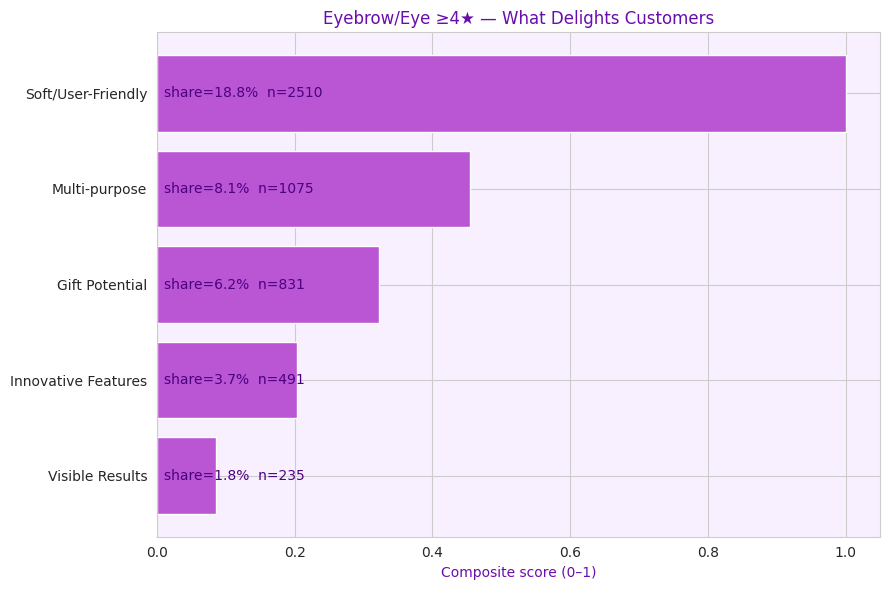

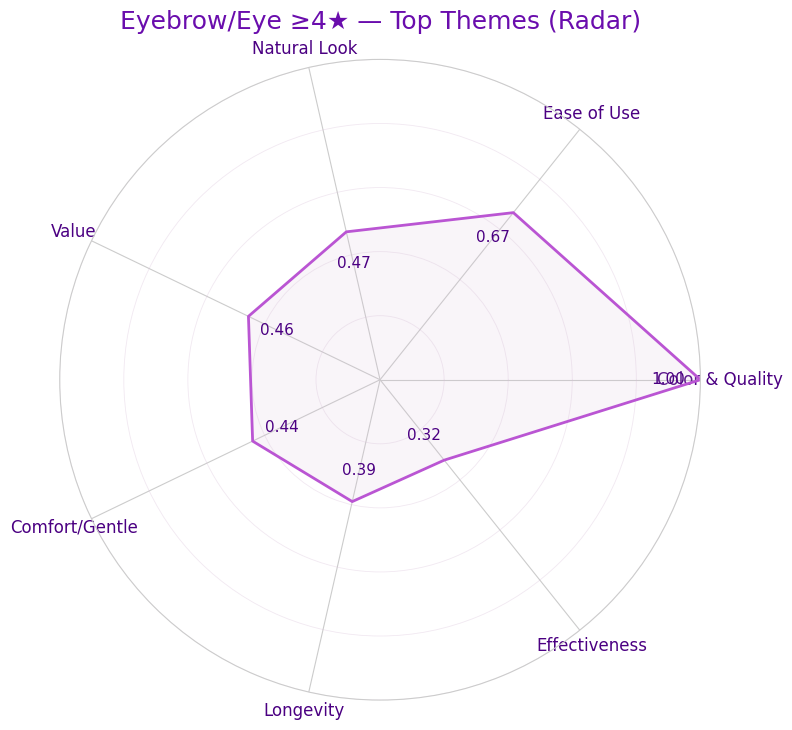

In [89]:
df = data_merged

cat = "Eye/Eyebrow Product"  # example
dfc = df[(df["beauty_category"]==cat) & df["review_content"].notna()].copy()
hi = dfc[dfc["rating"]>=4]
lo = dfc[dfc["rating"]<=2]
texts = hi["review_content"].dropna().astype(str).tolist()

hi = hi.copy()  # your filtered eyebrow/eye products, rating >= 4
if "helpful_vote" not in hi.columns:
    hi["helpful_vote"] = 0.0
hi["helpful_vote"] = pd.to_numeric(hi["helpful_vote"], errors="coerce").fillna(0.0)
text_series = hi["review_content"].fillna("").astype(str)

THEMES_GROUPED = {
    "Top Themes": {
        "Effectiveness": [
            r"\b(effectiv(e|eness)|results?|improv(e|ed|es)?|enhanc(e|es|ed)?|boost(s|ed)?|reduce(s|d)?\s+(dark\s*circles|puffiness|consistent))\b",
            r"\b(lash(es)?|brow(s)?|eyelash(es)?|eyebrow(s)?)\b.*\b(enhanc(e|es|ed)|volume|definition|lift)\b"
        ],
        "Ease of Use": [
            r"\b(simple|easy[-\s]?to[-\s]?use|quick|beginner|user[-\s]?friendly|effortless|straightforward|convenient)\b"
        ],
        "Longevity": [
            r"\b(long[-\s]?lasting|all[-\s]?day|durable|maintain(s|ed)?|stays?\s+put|smudge[-\s]?proof|wears?\s+well|holds\s+throughout\s+the\s+day)\b"
        ],
        "Color Variety and Quality": [
            r"\b(color|shade|range|variety|palette|tone)\b",
            r"\b(pigment(ed)?|rich|vibrant|bold|intense|high[-\s]?quality)\b"
        ],
        "Natural Look": [
            r"\b(natural|realistic|subtle|not\s+overdone|enhanc(e|es|ed)?\s+features)\b"
        ],
        "Value for Money": [
            r"\b(value|worth|affordab(le|ly)|cheap|deal|low|cost[-\s]?effective)\b"
        ],
        "Gentleness and Comfort": [
            r"\b(comfortable|non[-\s]?irritating|gentle|soft|safe\s+for\s+sensitive|sensitive\s+(skin|eyes)|eye[-\s]?friendly)\b"
        ],

    },
    "What Delights Customers": {
        "Visible Results": [
            r"\b(immediate|instant|noticeable|quick)\b.*\b(improv(e|ed|es|ement)|appearance|lash(es)?|brow(s)?|eye[s]?)\b",
            r"\b(boost(s|ed)?|enhanc(e|d)?|volume|definition|lift)\b"
        ],
        "Soft and User-Friendly": [
            r"\b(soft|smooth|luxurious|gentle|easy[-\s]?to[-\s]?use|pleasant\s+application|comfortable)\b",
            r"\b(brush|cosmetic|mask|tool|applicator|pencil|pen)\b"
        ],
        "Multi-purpose": [
            r"\b(multi[-\s]?use|multi[-\s]?purpose|double[-\s]?as|also|hydration|cooling|mask|eyeliner|brow\s+pencil)\b"
        ],
        "Gift Potential": [
            r"\b(gift|gift[-\s]?worthy|presentable|pretty|appealing|attractive|packag(e|ing)|design)\b"
        ],
        "Innovative Features": [
            r"\b(unique|innovative|special|cooling|user[-\s]?friendly|novel|new)\b",
            r"\b(new|mask|applicator|feature(s)?)\b"
        ]
    }
}

THEMES_RE = {
    group: {t: re.compile("|".join(pats), re.I) for t, pats in themes.items()}
    for group, themes in THEMES_GROUPED.items()
}

def score_group(texts, df, compiled_group):
    hits = {t: texts.str.contains(rx, regex=True) for t, rx in compiled_group.items()}
    counts = {t: m.sum() for t, m in hits.items()}
    N = len(texts)
    share = {t: counts[t]/max(N,1) for t in counts}

    helpful = pd.to_numeric(df["helpful_vote"], errors="coerce").fillna(0.0)
    w_sum = {t: float(helpful.loc[m].sum()) for t, m in hits.items()}

    max_w = max(w_sum.values()) if len(w_sum) else 1.0
    w_norm = {t: (w_sum[t]/max_w if max_w>0 else 0.0) for t in w_sum}

    max_share = max(share.values()) if len(share) else 1.0
    share_norm = {t: (share[t]/max_share if max_share>0 else 0.0) for t in share}

    score = {t: 0.8*share_norm[t] + 0.2*w_norm[t] for t in share}

    df_out = pd.DataFrame({
        "theme": list(counts.keys()),
        "count": list(counts.values()),
        "share": [share[t] for t in counts],
        "helpful_sum": [w_sum[t] for t in counts],
        "helpful_norm": [w_norm[t] for t in counts],
        "share_norm": [share_norm[t] for t in counts],
        "score": [score[t] for t in counts],
    }).sort_values("score", ascending=False).reset_index(drop=True)
    return df_out, hits

# compute all groups
group_scores, group_hits = {}, {}
for group, comp in THEMES_RE.items():
    df_out, hits = score_group(text_series, hi, comp)
    group_scores[group] = df_out
    group_hits[group] = hits


top_themes_label_map = {
    "Effectiveness": "Effectiveness",
    "Ease of Use": "Ease of Use",
    "Longevity": "Longevity",
    "Color Variety and Quality": "Color & Quality",
    "Natural Look": "Natural Look",
    "Value for Money": "Value",
    "Gentleness and Comfort": "Comfort/Gentle",
    "Positive User Experience": "User Experience"
}

delights_label_map = {
    "Visible Results": "Visible Results",
    "Soft and User-Friendly": "Soft/User-Friendly",
    "Multi-purpose": "Multi-purpose",
    "Gift Potential": "Gift Potential",
    "Innovative Features": "Innovative Features"
}


def plot_group_bar(df_group, title, topn=None, label_map=None):
    plot_df = df_group.copy()
    if topn:
        plot_df = plot_df.head(topn)
    plot_df = plot_df.iloc[::-1]  # reverse for horizontal bar chart

    # apply label_map
    plot_df["theme_label"] = plot_df["theme"].apply(lambda t: label_map.get(t, t) if label_map else t)

    plt.figure(figsize=(9,6))
    plt.barh(plot_df["theme_label"], plot_df["score"], color="#BA55D3")
    for i,(s,c) in enumerate(zip(plot_df["share"], plot_df["count"])):
        plt.text(0.01, i, f"share={s:.1%}  n={int(c)}", va="center", color="#4B0082")
    plt.xlabel("Composite score (0–1)", color="#6A0DAD")
    plt.title(title, color="#6A0DAD")
    plt.gca().set_facecolor("#F8F0FF")
    plt.tight_layout()
    plt.show()



def radar_plot_balanced(
    df_in,
    value_col="score",
    k=6,
    title="Theme Radar",
    label_map=None,
    show_rings=True,
    show_rlabels=False,
    wrap_width=16,
    sort_by_value=True
):
    dfp = df_in.head(k).copy().reset_index(drop=True)


    if sort_by_value:
        dfp = dfp.sort_values(value_col, ascending=False, ignore_index=True)

    raw_labels = dfp["theme"].tolist()
    labels = [label_map.get(t, t) for t in raw_labels] if label_map else raw_labels
    labels = [textwrap.fill(l, wrap_width) for l in labels]

    vals = dfp[value_col].to_numpy(float)
    values = vals.tolist() + [vals[0]]  # close the loop

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    if show_rings:
        rticks = [0.2, 0.4, 0.6, 0.8, 1.0]
        ax.set_yticks(rticks)
        ax.set_ylim(0, 1)
        ax.yaxis.grid(True, linestyle="-", linewidth=0.6, alpha=0.35, color="#D8BFD8")
        if show_rlabels:
            ax.set_yticklabels([f"{int(t*100)}%" for t in rticks], fontsize=10, color="#4B0082")
        else:
            ax.set_yticklabels([])
    else:
        ax.set_yticks([]); ax.set_yticklabels([]); ax.set_ylim(0, 1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12, color="#4B0082")

    # ---- Step 6: Draw radar ----
    ax.plot(angles, values, linewidth=2, color="#BA55D3")
    ax.fill(angles, values, alpha=0.15, color="#D8BFD8")

    # ---- Step 7: Annotate ----
    for ang, v in zip(angles[:-1], vals):
        ax.text(ang, max(0.06, v - 0.1), f"{v:.2f}", ha="center", va="center", fontsize=11, color="#4B0082")

    ax.set_title(title, pad=22, fontsize=18, color="#6A0DAD")
    plt.tight_layout()
    plt.show()

plot_group_bar(group_scores["What Delights Customers"],
               "Eyebrow/Eye ≥4★ — What Delights Customers",
               topn=8,
               label_map=delights_label_map)

radar_plot_balanced(group_scores["Top Themes"],
                    k=8,
                    title="Eyebrow/Eye ≥4★ — Top Themes (Radar)",
                    label_map=top_themes_label_map,
                    show_rings=True,
                    show_rlabels=False,
                    wrap_width=18)


For Eyebrow/Eye products soft and user friendly stands out as the most talked about topic. It also seems to be the product where highly rated products are those with great colors and quality

### Frequently Purchased together

To follow up with the earlier passing analysis we wanted to deepdive what products are being purchased together to help companies understand potential bundles they could create

Which products do customers buy together, what categories do they buy together how do they rate them?

Hair Products are bought together most frequently however they are rated the least favorably. Cream and lotions tend to be better rated


In [44]:
def _mode_or_first(s: pd.Series):
    m = s.mode(dropna=True)
    if len(m) > 0:
        return m.iloc[0]
    s = s.dropna()
    return s.iloc[0] if len(s) else None

asin_lookup = (
    data_merged
      .groupby("asin")
      .agg(product_name=("product_name", _mode_or_first),
           brand=("brand", _mode_or_first))
      .reset_index()
)

def get_name_and_category(asin: str):
    row = asin_lookup.loc[asin_lookup["asin"] == asin]
    if not row.empty:
        name = row.iloc[0]["product_name"] if pd.notna(row.iloc[0]["product_name"]) else asin
    else:
        name = asin
    return name, categorize_product(name)

user_product_lists = (
    data_merged.groupby("user_id")["asin"]
    .unique()
    .tolist()
)

combo_counter = Counter()
for plist in user_product_lists:
    if len(plist) > 1:
        for pair in combinations(sorted(plist), 2):  # sorting normalizes order (A,B) == (B,A)
            combo_counter[pair] += 1

combo_df = (
    pd.DataFrame(combo_counter.items(), columns=["product_pair", "num_users"])
      .sort_values("num_users", ascending=False)
      .reset_index(drop=True)
)

MIN_USERS = 3
combo_df = combo_df[combo_df["num_users"] >= MIN_USERS].reset_index(drop=True)

p1_asin = combo_df["product_pair"].apply(lambda x: x[0])
p2_asin = combo_df["product_pair"].apply(lambda x: x[1])

p1_names, p1_cats, p2_names, p2_cats = [], [], [], []
for a1, a2 in zip(p1_asin, p2_asin):
    n1, c1 = get_name_and_category(a1)
    n2, c2 = get_name_and_category(a2)
    p1_names.append(n1); p1_cats.append(c1)
    p2_names.append(n2); p2_cats.append(c2)

combo_df = combo_df.assign(
    product1_asin=p1_asin,
    product1_name=p1_names,
    product1_category=p1_cats,
    product2_asin=p2_asin,
    product2_name=p2_names,
    product2_category=p2_cats
)

cols_to_show = [
    "num_users",
    "product1_asin", "product1_name", "product1_category",
    "product2_asin", "product2_name", "product2_category"
]

In [45]:
# Clean numeric types
data_merged["price"] = pd.to_numeric(
    data_merged["price"].astype(str).str.replace(r"[\$,]", "", regex=True),
    errors="coerce"
)

rating_col = "rating" if "rating" in data_merged.columns else "average_rating"

product_stats = (
    data_merged.groupby("asin", dropna=False)
    .agg(
        product_name=("product_name", "first"),
        avg_price=("price", "mean"),
        avg_rating=(rating_col, "mean")
    )
    .reset_index()
)
p1 = product_stats.rename(columns={
    "asin": "product1_asin",
    "avg_price": "product1_price",
    "avg_rating": "product1_rating"
})

p2 = product_stats.rename(columns={
    "asin": "product2_asin",
    "avg_price": "product2_price",
    "avg_rating": "product2_rating"
})

combo_enriched = (
    combo_df
    .merge(p1[["product1_asin","product1_price","product1_rating"]], on="product1_asin", how="left")
    .merge(p2[["product2_asin","product2_price","product2_rating"]], on="product2_asin", how="left")
)

combo_enriched["pair_avg_price"]  = combo_enriched[["product1_price","product2_price"]].mean(axis=1)
combo_enriched["pair_avg_rating"] = combo_enriched[["product1_rating","product2_rating"]].mean(axis=1)

cols_to_show = [
    "num_users",
    "product1_name", "product1_price", "product1_rating",
    "product2_name", "product2_price", "product2_rating",
    "pair_avg_price", "pair_avg_rating"
]

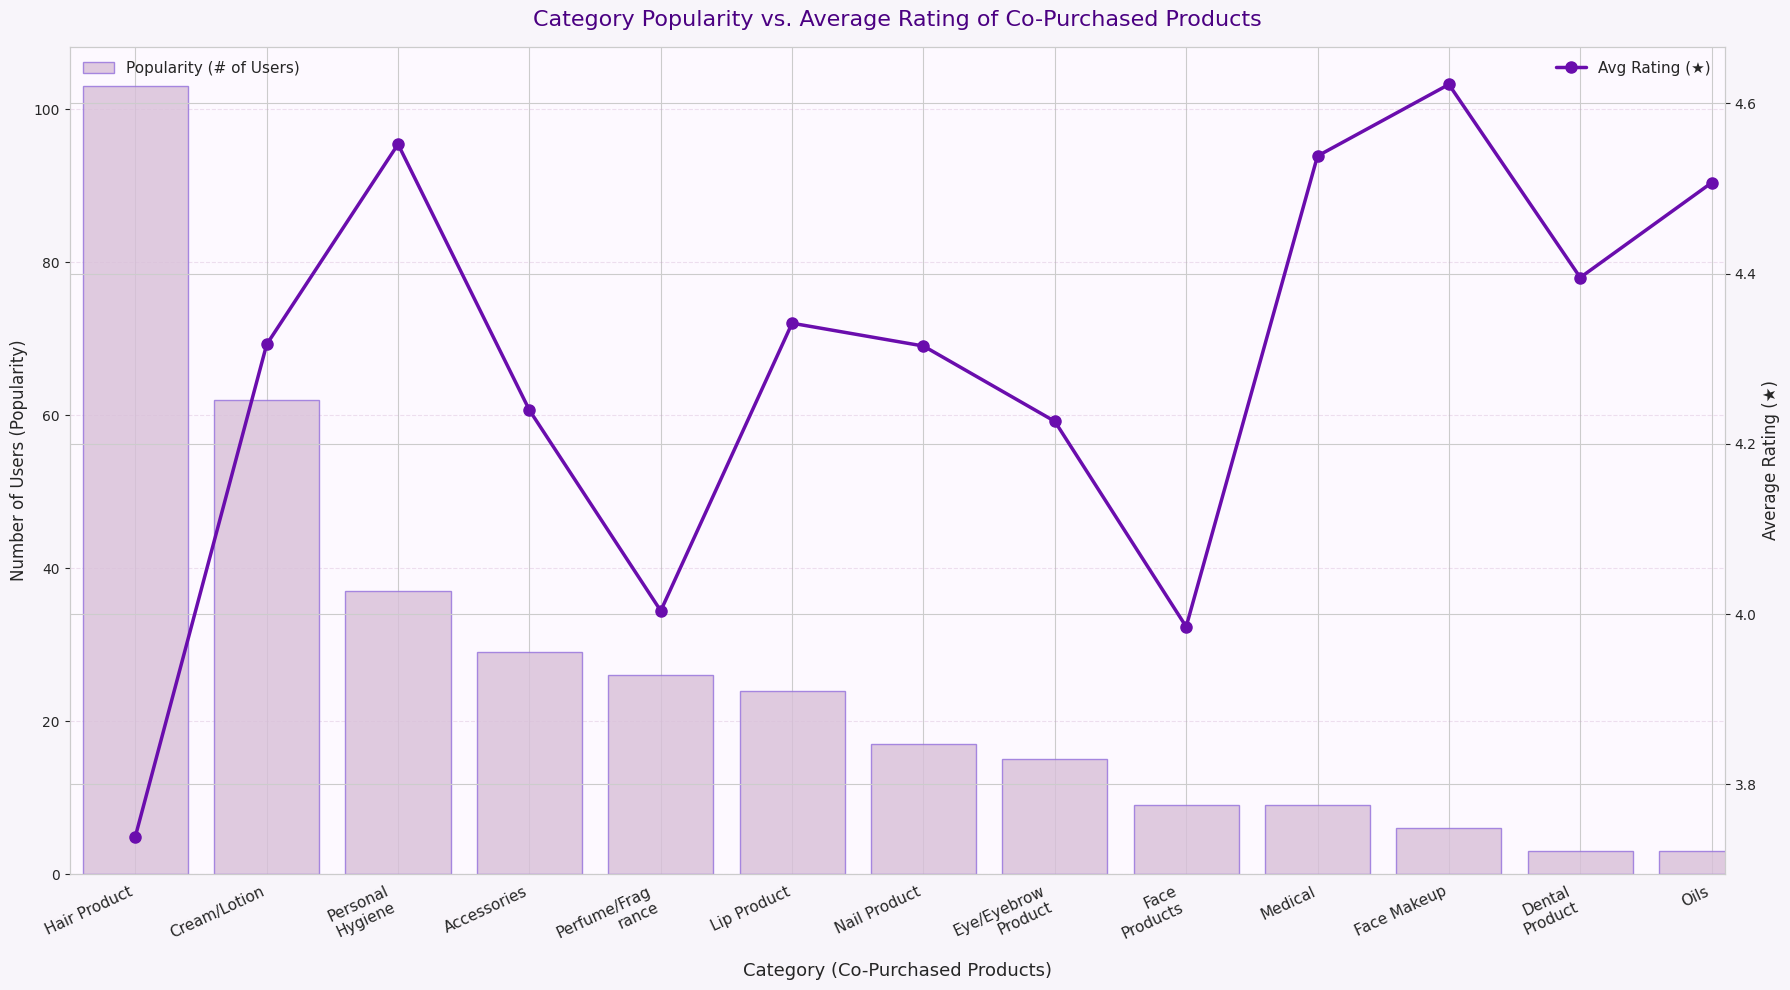

In [54]:
from textwrap import wrap

combo_enriched["product1_category"] = combo_enriched["product1_name"].fillna("").apply(categorize_product)
combo_enriched["product2_category"] = combo_enriched["product2_name"].fillna("").apply(categorize_product)

category_stats = (
    combo_enriched.groupby("product1_category")
    .agg(
        avg_rating=("pair_avg_rating", "mean"),
        total_users=("num_users", "sum")
    )
    .reset_index()
    .sort_values("total_users", ascending=False)
)

x = np.arange(len(category_stats))
categories = category_stats["product1_category"]
total_users = category_stats["total_users"]
avg_rating = category_stats["avg_rating"]

avg_label_len = np.mean([len(str(c)) for c in categories])
offset = 0.4 if avg_label_len > 12 else 0.2

fig, ax1 = plt.subplots(figsize=(18, 10))
ax2 = ax1.twinx()

ax1.bar(
    x,
    total_users,
    color="#D8BFD8",  # soft lavender
    edgecolor="#9370DB",  # medium purple outline
    alpha=0.8,
    label="Popularity (# of Users)",
    align='center'
)

ax2.plot(
    x,
    avg_rating,
    color="#6A0DAD",  # deep royal purple
    marker="o",
    markersize=8,
    linewidth=2.5,
    label="Avg Rating (★)"
)

categories_wrapped = ["\n".join(wrap(str(c), 12)) for c in categories]
ax1.set_xticks(x)
ax1.set_xticklabels(categories_wrapped, rotation=25, ha='right', fontsize=11)

left_pad = 0.5
right_pad = 0.1
ax1.set_xlim(-left_pad, len(x) - 1 + right_pad)
plt.subplots_adjust(left=0.10 + left_pad/12, right=0.92 - right_pad/12, bottom=0.25)

ax1.set_xlabel("Category (Co-Purchased Products)", fontsize=13)
ax1.set_ylabel("Number of Users (Popularity)", fontsize=12)
ax2.set_ylabel("Average Rating (★)", fontsize=12)
plt.title("Category Popularity vs. Average Rating of Co-Purchased Products",
          fontsize=16, color="#4B0082", pad=15)

# Legends
ax1.legend(loc="upper left", frameon=False, fontsize=11)
ax2.legend(loc="upper right", frameon=False, fontsize=11)

# Grid styling
ax1.grid(axis="y", linestyle="--", alpha=0.3, color="#C8A2C8")

fig.patch.set_facecolor("#F8F5FA")  # very light lavender background
ax1.set_facecolor("#FDF9FF")

plt.tight_layout()
plt.show()



/tmp/ipython-input-10582849.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = cm.get_cmap('PuRd', 256)


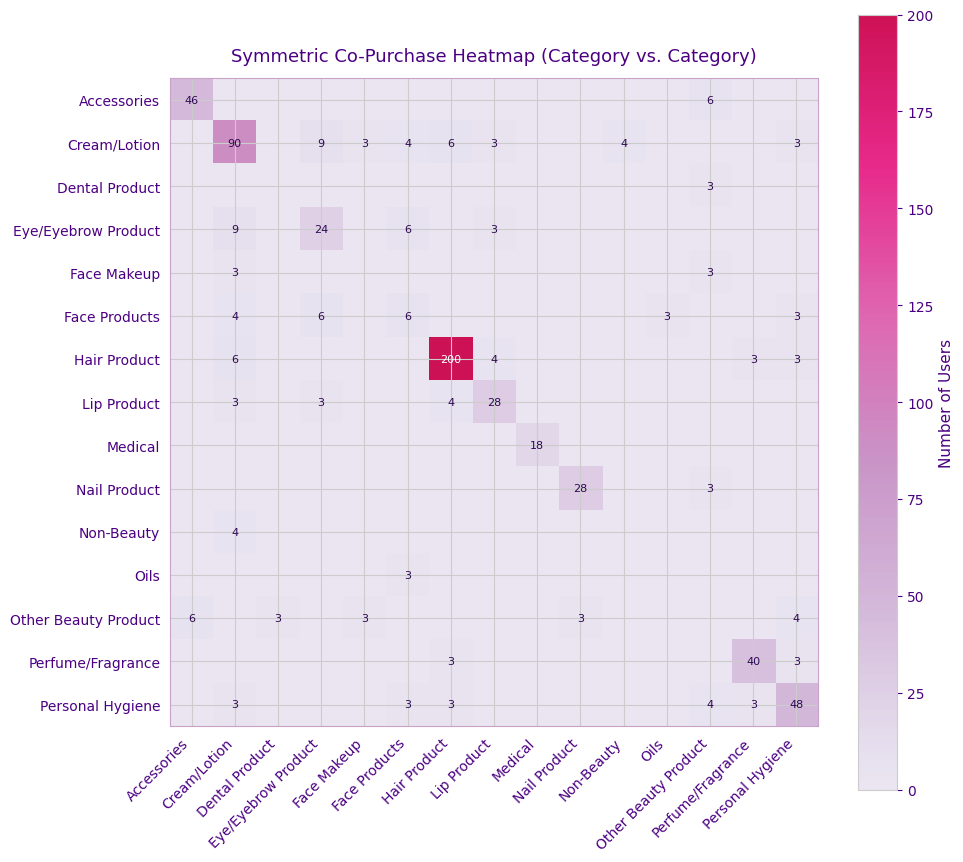

In [50]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

pairs_both = pd.concat([
    combo_df[["product1_category", "product2_category", "num_users"]],
    combo_df.rename(
        columns={"product1_category": "product2_category",
                 "product2_category": "product1_category"}
    )[["product1_category", "product2_category", "num_users"]]
], ignore_index=True)

agg = (pairs_both
       .groupby(["product1_category", "product2_category"], as_index=False)["num_users"]
       .sum())

pivot_sym = pd.pivot_table(
    agg,
    index="product1_category",
    columns="product2_category",
    values="num_users",
    aggfunc="sum",
    fill_value=0
)

cats = sorted(set(pivot_sym.index) | set(pivot_sym.columns))
pivot_sym = pivot_sym.reindex(index=cats, columns=cats, fill_value=0)

base_cmap = cm.get_cmap('PuRd', 256)
new_cmap = ListedColormap(base_cmap(np.linspace(0.1, 0.75, 256)))  # keeps lighter-to-mid purple

fig, ax = plt.subplots(figsize=(10, 9))
im = ax.imshow(pivot_sym.values, aspect="equal", cmap=new_cmap)


ax.set_xticks(np.arange(pivot_sym.shape[1]))
ax.set_xticklabels(pivot_sym.columns, rotation=45, ha="right", color="#4B0082", fontsize=10)
ax.set_yticks(np.arange(pivot_sym.shape[0]))
ax.set_yticklabels(pivot_sym.index, color="#4B0082", fontsize=10)


cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Number of Users", rotation=90, fontsize=11, color="#4B0082")
cbar.ax.yaxis.set_tick_params(color="#4B0082")
plt.setp(cbar.ax.get_yticklabels(), color="#4B0082")

for i in range(pivot_sym.shape[0]):
    for j in range(pivot_sym.shape[1]):
        val = pivot_sym.iat[i, j]
        if val > 0:
            color = "white" if pivot_sym.iat[i, j] > pivot_sym.values.max() * 0.6 else "#2E0854"
            ax.text(j, i, int(val), ha="center", va="center", fontsize=8, color=color)

ax.set_title("Symmetric Co-Purchase Heatmap (Category vs. Category)",
             fontsize=13, color="#4B0082", pad=12)
for spine in ax.spines.values():
    spine.set_color("#C8A2C8")

plt.tight_layout()
plt.show()

The heatmap shows products customers bought together. It highlights firstly that customers bought products in the same category most frequently together. Additionaly most often hair products .i.e. shampoos, conditioners, brushes are bought together most followed closely by cream and lotions. Companies could use this information to create bundles.

## Conclusion




###Main Conclusion

The analysis reveals the following:

*   80%+ of reviews show positive sentiment; customers highlight likes first and avoid strong negatives.


*   Top 3 categories: Hair Products, Cream/Lotion, Eye/Eyebrow Products.
*   Key satisfaction drivers: Ease of use, effectiveness and value for money


*   Repurchase & co-purchase: Nail Products, Cream/Lotion, and Perfume are most rebought.










After extensive analysis we can make reliable recommendations to companies operating in the top 3 categories of beauty products sold: hair, cream/lotions and eye/eyebrow products. Additionally, we can reliably recommend creating bundles in the same product to create better value for customers.

###Risks and Limitations


*   Rating data is biased (extreme positive and negative reviews are overrepresented) and may not reflect the full customer experience.
*   The repeat “purchase” analysis actually covers only repeat reviews on different dates, which likely underestimates true repurchase behavior (customers may repurchase but not leave another review, or purchase multiple times on the same day).


*   Reviews and helpful votes may be influenced by platform rules, brand promotions, free samples, or marketing incentives.
*   The dataset lacks actual sales quantities, so popularity and repurchase behavior can only be inferred indirectly from review counts.
*   Categorization is to the best of our abilities and derived from product names which might not always contain their proper category or may overlap with anoth category. The other beauty category remains the largest


###Challenges and Next Steps


**Challenges**
*   The first challenge was the quality of data which mostly did not include prices and categories of beauty products. It resulted in a large part of the dataset being dropped. Additionally categories might not be accurate as they are based off product names.
*   The next challenge was analyzing the reviews themselves, these were text heavy so needed an LLM. We used the GPTmini-o4 however due to the time and cost we limited the analysis to top 3 categories. A better LLM might yield better results


**Next Steps**

Introduce Statistical Standards

Define and apply standardized metrics (e.g., repeat-purchase rate, cross-purchase rate, average rating variance, review-length distribution) to more accurately show the real condition of each issue.

Deepen Text Analysis

Building on the analysis done by LLM on category an extensive project could make a system which takes an input .i.e. product and gives similar visualizations for it. It could prove invaluable for competitor analysis

## Generative AI Disclosure

We have utilized CHATGPT to assist with our project and findings.


*   Content generation: We use CHATGPT to brainstorm ideas including making plots, sorting data that we are interested in in order to provide insightful analysis. It was also used to execute some of the ideas that were beyond our technical abilites but essential for the analysis.

*   Code debugging : We use CHATGPT to improve and debug some of the errors in our python code, specifically in generating figures and analysis.

*   Proofreading and Grammar Checks : We use CHATGPT to refine our writing, improve readability and ensure grammatical accuracy.





